In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Dataset 2

In [25]:
# Caminhos do D2
D2_BASE    = "/content/drive/MyDrive/TCC/D2"
D2_IMG_DIR = os.path.join(D2_BASE, "image")
D2_CSV     = os.path.join(D2_BASE, "MetaData.csv")

In [26]:
IMG_SIZE        = 224
BATCH_SIZE      = 32
AUTOTUNE        = tf.data.AUTOTUNE
MANTER_PROPORCAO = False

In [27]:
def split_70_15_15_por_classe(df, label_col="gender", rnd=12):
    rng = np.random.RandomState(rnd)
    partes_train, partes_val, partes_test = [], [], []
    for cls, g in df.groupby(label_col):
        n = len(g)
        if n == 1:
            partes_train.append(g)  # 1 amostra -> treino
            continue
        n_val  = max(1, int(round(0.15 * n)))
        n_test = max(1, int(round(0.15 * n)))
        if n_val + n_test >= n:
            n_val, n_test = 1, 1
        g = g.sample(frac=1.0, random_state=rng.randint(0, 10**6)).reset_index(drop=True)
        partes_val.append(g.iloc[:n_val])
        partes_test.append(g.iloc[n_val:n_val+n_test])
        partes_train.append(g.iloc[n_val+n_test:])
    df_tr = pd.concat(partes_train, ignore_index=True).sample(frac=1.0, random_state=rnd).reset_index(drop=True)
    df_va = pd.concat(partes_val,   ignore_index=True).sample(frac=1.0, random_state=rnd).reset_index(drop=True)
    df_te = pd.concat(partes_test,  ignore_index=True).sample(frac=1.0, random_state=rnd).reset_index(drop=True)
    return df_tr, df_va, df_te

In [28]:
df2 = pd.read_csv(D2_CSV)
df2["imageId"] = df2["id"].astype(int).astype(str) + ".png"
df2["__ok__"]  = df2["imageId"].apply(lambda f: os.path.exists(os.path.join(D2_IMG_DIR, f)))
df2 = df2[df2["__ok__"]].drop(columns="__ok__").reset_index(drop=True)

df2_train, df2_val, df2_test = split_70_15_15_por_classe(df2, label_col="gender", rnd=12)
print("Split D2 ->", len(df2_train), len(df2_val), len(df2_test))
print("Distrib treino:", df2_train["gender"].value_counts().to_dict())

Split D2 -> 490 107 107
Distrib treino: {'male': 250, 'female': 124, 'F': 52, 'M': 45, 'Male': 8, 'Male,': 4, 'Female,': 3, 'Female': 1, 'O': 1, 'female24yrs': 1, 'femal': 1}


In [29]:
train_dir = tf.constant(D2_IMG_DIR)

def CarregarEPreprocessarD2(filename):
    img_path = tf.strings.join([train_dir, filename], separator='/')
    image_bytes = tf.io.read_file(img_path)
    image = tf.image.decode_png(image_bytes, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    if MANTER_PROPORCAO:
        image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    else:
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image  # retorna só X; formaremos (X,X) com zip

In [30]:
def DatasetAE(ids_series):
    ds_x = (tf.data.Dataset
            .from_tensor_slices(ids_series.astype(str).values)
            .map(CarregarEPreprocessarD2, num_parallel_calls=AUTOTUNE))
    ds = tf.data.Dataset.zip((ds_x, ds_x))  # (x, x)
    ds = ds.shuffle(min(10000, len(ids_series))) \
           .batch(BATCH_SIZE) \
           .repeat() \
           .prefetch(AUTOTUNE)
    return ds

d2_train_ds_ae = DatasetAE(df2_train["imageId"])
d2_val_ds_ae   = DatasetAE(df2_val["imageId"])


In [31]:
steps_per_epoch  = max(1, int(np.ceil(len(df2_train) / BATCH_SIZE)))
validation_steps = max(1, int(np.ceil(len(df2_val)   / BATCH_SIZE)))
print("steps_per_epoch:", steps_per_epoch, "| validation_steps:", validation_steps)

steps_per_epoch: 16 | validation_steps: 4


### Autoencoder 2

In [ ]:
autoencoder = models.Sequential(name="AutoencoderD2")

# ENCODER
autoencoder.add(layers.Input(shape=(224, 224, 1)))
autoencoder.add(layers.Conv2D(48, (3, 3), padding='same', activation='relu'))
autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))     # 112x112x48
autoencoder.add(layers.Conv2D(96, (3, 3), padding='same', activation='relu'))
autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))     # 56x56x96
autoencoder.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))     # 28x28x128
autoencoder.add(layers.Conv2D(160, (3, 3), padding='same', activation='relu'))
autoencoder.add(layers.MaxPooling2D((2, 2), padding='same', name="encoder_out"))  # 14x14x160

# DECODER
autoencoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu'))  # 28x28x128
autoencoder.add(layers.Conv2DTranspose(96, (3, 3), strides=2, padding='same', activation='relu'))   # 56x56x96
autoencoder.add(layers.Conv2DTranspose(48, (3, 3), strides=2, padding='same', activation='relu'))   # 112x112x48
autoencoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'))   # 224x224x32
autoencoder.add(layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid'))                     # 224x224x1

autoencoder.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
autoencoder.summary()

Model: "AutoencoderD2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 48)   │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 96)   │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 160)    │       184,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_out (MaxPooling2D)      │ (None, 14, 14, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 128)    │       184,448 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 56, 56, 96)     │       110,688 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 112, 112, 48)   │        41,520 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 224, 224, 32)   │        13,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,049 (2.62 MB)

 Trainable params: 688,049 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Salvar os logs do modelo
log_dir = "/content/drive/MyDrive/TCC/logs"
os.makedirs(log_dir, exist_ok=True)

log_path = os.path.join(log_dir, "treino_autoencoder2.csv")

# Cria o logger
csv_logger = CSVLogger(log_path, append=False)

In [ ]:
history = autoencoder.fit(
    d2_train_ds_ae,
    validation_data=d2_val_ds_ae,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=30,
    callbacks=[csv_logger],
)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - loss: 0.0799 - val_loss: 0.0654
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 546ms/step - loss: 0.0600 - val_loss: 0.0480
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 568ms/step - loss: 0.0463 - val_loss: 0.0402
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 573ms/step - loss: 0.0371 - val_loss: 0.0371
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 555ms/step - loss: 0.0353 - val_loss: 0.0354
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 544ms/step - loss: 0.0351 - val_loss: 0.0344
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 548ms/step - loss: 0.0336 - val_loss: 0.0333
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0321 - val_loss: 0.0314
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 597ms/step - loss: 0.0256 - val_loss: 0.0098
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 507ms/step - loss: 0.0085 - val_loss: 0.0065
Epoch 11/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 525ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 12/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/st

In [ ]:
encoder_output = autoencoder.layers[4].output
encoder = Model(inputs=autoencoder.layers[0].input, outputs=encoder_output, name="Encoder")
encoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 48)   │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 96)   │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       110,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,768 (596.75 KB)

 Trainable params: 152,768 (596.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Cria o feature_model
gap = layers.GlobalAveragePooling2D(name="gap")(encoder.output)
feature_model = Model(inputs=encoder.input, outputs=gap, name="FeatureModel")
feature_model.summary()

Model: "FeatureModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 48)   │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 96)   │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,768 (596.75 KB)

 Trainable params: 152,768 (596.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Verificação
print("Encoder output shape:", encoder.output_shape)
print("FeatureModel output shape:", feature_model.output_shape)

Encoder output shape: (None, 56, 56, 128)
FeatureModel output shape: (None, 128)


In [ ]:
BASE_MODELS = "/content/drive/MyDrive/TCC/models"

# Função para salvar os modelos
def SalvarModelos(encoder, nome_base, pasta=BASE_MODELS, feature_model=None, autoencoder=None):
    os.makedirs(pasta, exist_ok=True)
    caminhos = {}

    caminho_encoder = os.path.join(pasta, f"{nome_base}_encoder.keras")
    encoder.save(caminho_encoder)
    caminhos["encoder"] = caminho_encoder

    if feature_model is not None:
        caminho_feature = os.path.join(pasta, f"{nome_base}_feature.keras")
        feature_model.save(caminho_feature)
        caminhos["feature_model"] = caminho_feature

    if autoencoder is not None:
        caminho_auto = os.path.join(pasta, f"{nome_base}_autoencoder.keras")
        autoencoder.save(caminho_auto)
        caminhos["autoencoder"] = caminho_auto

    return caminhos

In [ ]:
BASE_MODELS = "/content/drive/MyDrive/TCC/models"
paths = SalvarModelos(encoder, nome_base="AE_D2", feature_model=feature_model, autoencoder=autoencoder)
print(paths)

{'encoder': '/content/drive/MyDrive/TCC/models/AE_D2_encoder.keras', 'feature_model': '/content/drive/MyDrive/TCC/models/AE_D2_feature.keras', 'autoencoder': '/content/drive/MyDrive/TCC/models/AE_D2_autoencoder.keras'}


### SVM Encoder 2 ➜ Dataset 2

In [32]:
D2_BASE = "/content/drive/MyDrive/TCC/D2"
D2_IMG_DIR = os.path.join(D2_BASE, "image")
D2_CSV = os.path.join(D2_BASE, "MetaData.csv")
BASE_MODELS = "/content/drive/MyDrive/TCC/models"

# 1) Carrega o feature_model do AE1 (encoder + GAP)
feature_model = load_model(f"{BASE_MODELS}/AE_D2_feature.keras", compile=False)

In [33]:
# 2) Lê D2 e prepara splits 70/15/15 por 'gender'
df2 = pd.read_csv(D2_CSV)
df2["imageId"] = df2["id"].astype(int).astype(str) + ".png"

In [34]:
df2_train, df2_val, df2_test = split_70_15_15_por_classe(df2, label_col="gender", rnd=12)
print("Split D2 ->", len(df2_train), len(df2_val), len(df2_test))

Split D2 -> 490 107 107


In [35]:
AUTOTUNE = tf.data.AUTOTUNE

def DatasetSoImagens(ids, root_dir=None, batch_size=32, shuffle=True, img_size=(224,224), channels=1):
    """
    Cria um tf.data.Dataset SÓ DE IMAGENS para o D2.
    - ids: pandas Series/array com 'imageId' (pode vir sem extensão/padding).
    - root_dir: por padrão usa D2_IMG_DIR.
    - Tenta resolver .png/.jpg com paddings {0,6,7}. Filtra faltantes.
    """
    if root_dir is None:
        root_dir = D2_IMG_DIR  # usa D2 por padrão
    h, w = img_size

    def _resolve_one(img_id: str) -> str | None:
        base = str(img_id).strip()
        name, ext = os.path.splitext(base)
        cands = []
        if ext.lower() in (".png", ".jpg", ".jpeg"):
            cands += [os.path.join(root_dir, base),
                      os.path.join(root_dir, name + (".jpg" if ext.lower()==".png" else ".png"))]
        else:
            for pad in (0, 6, 7):
                n = name.zfill(pad) if pad>0 else name
                for e in (".png", ".jpg"):
                    cands.append(os.path.join(root_dir, n + e))
        for c in cands:
            if os.path.exists(c):
                return c
        return None

    ids_np = np.asarray(ids).astype(str)
    paths = [p for p in ( _resolve_one(x) for x in ids_np ) if p is not None]
    miss  = len(ids_np) - len(paths)
    if miss:
        print(f"[D2] Aviso: {miss} arquivos não encontrados em {root_dir}. (filtrados)")

    if len(paths) == 0:
        raise RuntimeError(f"Nenhuma imagem encontrada em {root_dir} para os IDs fornecidos.")

    paths_tf = tf.constant(paths)

    def _load(path):
        bytes_ = tf.io.read_file(path)
        is_png = tf.strings.regex_full_match(path, r".*\.png$")
        img = tf.cond(is_png,
                      lambda: tf.image.decode_png(bytes_, channels=channels),
                      lambda: tf.image.decode_jpeg(bytes_, channels=channels))
        img = tf.image.resize(img, [h, w])
        img = tf.cast(img, tf.float32) / 255.0
        return img

    ds = tf.data.Dataset.from_tensor_slices(paths_tf)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), reshuffle_each_iteration=True)
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

In [36]:
# 3) tf.data só com imagens do D2 (usa seu CarregarEPreprocessar)
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
train_dir = tf.constant(D2_IMG_DIR)

d2_train_ds = DatasetSoImagens(df2_train["imageId"], shuffle=True)
d2_val_ds   = DatasetSoImagens(df2_val["imageId"],   shuffle=False)
d2_test_ds  = DatasetSoImagens(df2_test["imageId"],  shuffle=False)

In [37]:
# 4) Embeddings com o feature_model do AE2
X_tr_D2 = feature_model.predict(d2_train_ds, verbose=0)
X_va_D2 = feature_model.predict(d2_val_ds,   verbose=0)
X_te_D2 = feature_model.predict(d2_test_ds,  verbose=0)

y_tr_D2 = df2_train["gender"].values
y_va_D2 = df2_val["gender"].values
y_te_D2 = df2_test["gender"].values

print(X_tr_D2.shape, X_va_D2.shape, X_te_D2.shape)


(490, 128) (107, 128) (107, 128)


In [38]:
def FormatarSaida(x: float) -> str:
    return f"{x*100:.2f}%".replace('.', ',')

In [39]:
#SVM
# 5) SVM (mesmo formato que você pediu)
AVG = 'weighted'
scaler_D2 = StandardScaler()
Xtr = scaler_D2.fit_transform(X_tr_D2)
Xva = scaler_D2.transform(X_va_D2)
Xte = scaler_D2.transform(X_te_D2)

svm_D2 = SVC(kernel='linear', class_weight=None, random_state=42)
svm_D2.fit(Xtr, y_tr_D2)

y_va_pred = svm_D2.predict(Xva)
y_te_pred = svm_D2.predict(Xte)

acc_va = accuracy_score(y_va_D2, y_va_pred)
f1_va  = f1_score(y_va_D2, y_va_pred, average=AVG)
acc_te = accuracy_score(y_te_D2, y_te_pred)
f1_te  = f1_score(y_te_D2, y_te_pred, average=AVG)

print("Validação")
print("Acurácia (Val):", FormatarSaida(acc_va))
print("F1 (Val):",      FormatarSaida(f1_va))
print("\nTeste")
print("Acurácia (Test):", FormatarSaida(acc_te))
print("F1 (Test):",       FormatarSaida(f1_te))

Validação
Acurácia (Val): 50,47%
F1 (Val): 34,07%

Teste
Acurácia (Test): 50,47%
F1 (Test): 33,85%


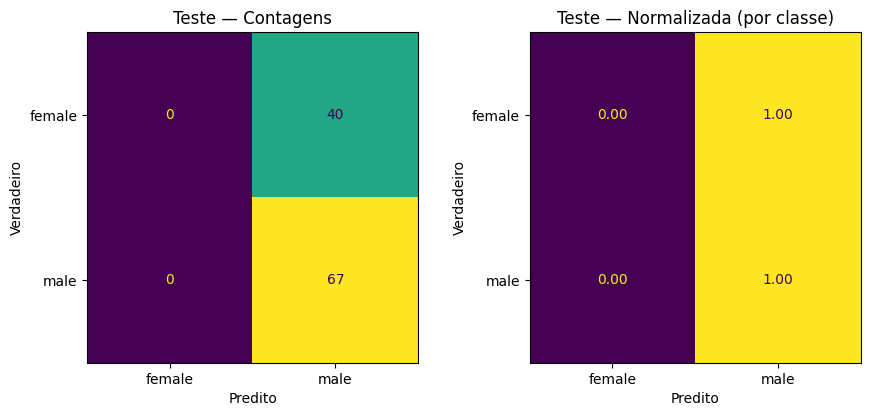


=== Classification report (Teste, somente female/male) ===
              precision    recall  f1-score   support

      female       0.00      0.00      0.00        40
        male       0.63      1.00      0.77        67

    accuracy                           0.63       107
   macro avg       0.31      0.50      0.39       107
weighted avg       0.39      0.63      0.48       107



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
# ===== Normalização de rótulos e matriz de confusão (TESTE) — D2 =====
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def norm_gender(x: str) -> str:
    s = str(x).strip().lower()
    # fêmina
    if s in {"f", "female", "feminino"} or s.startswith(("fem", "female")):
        return "female"
    # masculino
    if s in {"m", "male", "masculino"} or s.startswith(("mal", "male")):
        return "male"
    # casos tipo 'female,' 'male,' 'male35yrs', 'female-xyz'
    if s.replace(",", "").startswith("female"):
        return "female"
    if s.replace(",", "").startswith("male"):
        return "male"
    return "unknown"

# 1) normaliza verdadeiros e predições
y_tr_D2_n = np.array([norm_gender(v) for v in y_tr_D2])
y_va_D2_n = np.array([norm_gender(v) for v in y_va_D2])
y_te_D2_n = np.array([norm_gender(v) for v in y_te_D2])

y_va_pred_n = np.array([norm_gender(v) for v in y_va_pred])
y_te_pred_n = np.array([norm_gender(v) for v in y_te_pred])

# 2) (opcional) filtra amostras que não sejam female/male
VALID = {"female", "male"}
mask_te = np.isin(y_te_D2_n, list(VALID)) & np.isin(y_te_pred_n, list(VALID))
y_te_clean = y_te_D2_n[mask_te]
y_pr_clean = y_te_pred_n[mask_te]

# 3) Confusion matrix com ordem fixa
CLASSES = np.array(["female", "male"])

cm_test      = confusion_matrix(y_te_clean, y_pr_clean, labels=CLASSES)
cm_test_norm = confusion_matrix(y_te_clean, y_pr_clean, labels=CLASSES, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(9, 4.2))

disp_cnt = ConfusionMatrixDisplay(cm_test, display_labels=CLASSES)
disp_cnt.plot(ax=axes[0], values_format="d", colorbar=False)
axes[0].set_title("Teste — Contagens")
axes[0].set_xlabel("Predito"); axes[0].set_ylabel("Verdadeiro")

disp_norm = ConfusionMatrixDisplay(cm_test_norm, display_labels=CLASSES)
disp_norm.plot(ax=axes[1], values_format=".2f", colorbar=False)
axes[1].set_title("Teste — Normalizada (por classe)")
axes[1].set_xlabel("Predito"); axes[1].set_ylabel("Verdadeiro")

plt.tight_layout()

out_dir = Path("/content/drive/MyDrive/TCC/outputs")
out_dir.mkdir(parents=True, exist_ok=True)
fname = "matriz_confusao_D2_test.png"
fig.savefig(out_dir / fname, dpi=180, bbox_inches="tight")

plt.show()

print("\n=== Classification report (Teste, somente female/male) ===")
print(classification_report(y_te_clean, y_pr_clean, target_names=[str(c) for c in CLASSES]))


### SVM Encoder 2 ➜ Dataset 1

In [ ]:
BASE_MODELS   = "/content/drive/MyDrive/TCC/models"
dataset1      = "/content/drive/MyDrive/TCC/D1"
dataset1Train = "/content/drive/MyDrive/TCC/D1/train"
csv_path      = "/content/drive/MyDrive/TCC/D1/train_gender.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

# Encoder (GAP / feature extractor) treinado no D2
feature_model = load_model(f"{BASE_MODELS}/AE_D2_feature.keras", compile=False)
feature_model.summary()

Model: "FeatureModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 48)   │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 96)   │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,768 (596.75 KB)

 Trainable params: 152,768 (596.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Lê CSV
df = pd.read_csv(csv_path)

# Normaliza nomes esperados
if 'imageId' not in df.columns and 'Image Index' in df.columns:
    df = df.rename(columns={'Image Index': 'imageId'})
if 'gender' not in df.columns and 'Gender' in df.columns:
    df = df.rename(columns={'Gender': 'gender'})

# Sanidade básica
assert {'imageId','gender'}.issubset(df.columns), df.columns

# Remove linhas com missing
df = df.dropna(subset=['imageId','gender']).copy()
df['imageId'] = df['imageId'].astype(str)

# Split base 80/20 estratificado
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=12, stratify=df['gender']
)

len(train_df), len(test_df), train_df['gender'].value_counts(normalize=True), test_df['gender'].value_counts(normalize=True)


(8561,
 2141,
 gender
 0    0.580189
 1    0.419811
 Name: proportion, dtype: float64,
 gender
 0    0.580103
 1    0.419897
 Name: proportion, dtype: float64)

In [ ]:
rng = np.random.RandomState(12)

def amostrar_estratificado_keep_index(df_src, n_total, label_col="gender"):
    partes = []
    for cls, g in df_src.groupby(label_col):
        prop = len(g) / len(df_src)
        n_cls = max(1, int(round(prop * n_total)))
        # sample sem resetar índice para preservar índices originais
        partes.append(g.sample(n=min(n_cls, len(g)), random_state=rng.randint(0, 10**6)))
    out = pd.concat(partes).sample(frac=1.0, random_state=12)  # embaralha sem resetar índice
    if len(out) > n_total:
        out = out.iloc[:n_total]
    return out

train_df1_2000 = amostrar_estratificado_keep_index(train_df, n_total=2000, label_col="gender")
test_df1_1000  = amostrar_estratificado_keep_index(test_df,  n_total=1000,  label_col="gender")
resto_train    = train_df.drop(train_df1_2000.index)
val_df1_500    = amostrar_estratificado_keep_index(resto_train, n_total=500, label_col="gender")

print("Tamanhos (reduzidos):", len(train_df1_2000), len(test_df1_1000), len(val_df1_500))


Tamanhos (reduzidos): 2000 1000 500


In [ ]:
# >>> SEM subpasta "image"
train_dir_py = dataset1Train  # "/content/drive/MyDrive/TCC/D1/train"
print("Usando imagens de:", train_dir_py)

def _build_lookups(img_dir):
    # Lista todos os arquivos diretamente em train/
    files = os.listdir(img_dir)
    files = [f for f in files if not f.startswith('.')]  # ignora ocultos / thumbs
    by_stem = {}
    by_stem_nolead0 = {}
    for f in files:
        stem, ext = os.path.splitext(f)
        by_stem[stem] = f
        by_stem_nolead0[stem.lstrip('0')] = f
    return set(files), by_stem, by_stem_nolead0

file_set, by_stem, by_stem_nolead0 = _build_lookups(train_dir_py)

def resolver_caminhos(image_ids: pd.Series, img_dir: str):
    """
    Tenta achar o arquivo correto para cada imageId:
    - match exato do stem
    - stem sem zeros à esquerda
    - tenta .png/.jpg/.jpeg e zero-padding (6 e 7 dígitos)
    """
    image_ids = image_ids.astype(str)
    exts = [".png", ".jpg", ".jpeg"]
    paths, ok_index = [], []

    for idx, iid in image_ids.items():
        iid_str = iid.strip()

        # Se já vier com extensão e existir, aceita
        base = os.path.basename(iid_str)
        if base in file_set:
            paths.append(os.path.join(img_dir, base))
            ok_index.append(idx)
            continue

        stem = os.path.splitext(base)[0]

        # 1) match exato (sem extensão)
        if stem in by_stem:
            paths.append(os.path.join(img_dir, by_stem[stem]))
            ok_index.append(idx)
            continue

        # 2) sem zeros à esquerda
        key = stem.lstrip('0')
        if key in by_stem_nolead0:
            paths.append(os.path.join(img_dir, by_stem_nolead0[key]))
            ok_index.append(idx)
            continue

        # 3) tenta extensões e zero-padding
        found = False
        for ext in exts:
            cand = stem + ext
            if cand in file_set:
                paths.append(os.path.join(img_dir, cand))
                ok_index.append(idx)
                found = True
                break
            for z in (6, 7):
                cand = stem.zfill(z) + ext
                if cand in file_set:
                    paths.append(os.path.join(img_dir, cand))
                    ok_index.append(idx)
                    found = True
                    break
            if found:
                break
        # se não achou, ignora; veremos a contagem depois

    return paths, ok_index

def montar_ds_so_imagens(df_subset: pd.DataFrame):
    """
    Retorna:
      - ds: tf.data.Dataset só de imagens (batched)
      - df_ok: df_subset filtrado apenas nas linhas com imagem encontrada
      - paths: lista de caminhos de imagem usados
    """
    paths, ok_index = resolver_caminhos(df_subset['imageId'], train_dir_py)
    df_ok = df_subset.loc[ok_index].copy()
    if len(paths) == 0:
        raise RuntimeError(
            "Nenhuma imagem encontrada. Confira 'imageId' no CSV e os nomes reais em " + train_dir_py
        )

    def CarregarEPreprocessar(caminho):
        img = tf.io.read_file(caminho)
        img = tf.image.decode_image(img, channels=1, expand_animations=False)  # use 3 se for RGB
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        return img

    paths_tf = tf.constant(paths)
    ds = tf.data.Dataset.from_tensor_slices(paths_tf)
    ds = ds.map(CarregarEPreprocessar, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds, df_ok, paths

# (opcional) checagem rápida de amostras no diretório
sample = sorted(list(file_set))[:5]
print("Alguns arquivos no diretório:", sample)


Usando imagens de: /content/drive/MyDrive/TCC/D1/train
Alguns arquivos no diretório: ['000000.png', '000001.png', '000002.png', '000003.png', '000004.png']


In [ ]:
train_images_ds, train_df_ok, train_paths = montar_ds_so_imagens(train_df1_2000)
val_images_ds,   val_df_ok,   val_paths   = montar_ds_so_imagens(val_df1_500)
test_images_ds,  test_df_ok,  test_paths  = montar_ds_so_imagens(test_df1_1000)

print("Encontradas (train/val/test):", len(train_df_ok), len(val_df_ok), len(test_df_ok))
# Se houver queda, é normal: eram IDs sem arquivo correspondente.


Encontradas (train/val/test): 2000 500 1000


In [ ]:
X_train = feature_model.predict(train_images_ds, verbose=0)
X_val   = feature_model.predict(val_images_ds,   verbose=0)
X_test  = feature_model.predict(test_images_ds,  verbose=0)

y_train = train_df_ok['gender'].values
y_val   = val_df_ok['gender'].values
y_test  = test_df_ok['gender'].values

print("Shapes (train/val/test):", X_train.shape, X_val.shape, X_test.shape)
print("Distribuição treino:", np.unique(y_train, return_counts=True))


Shapes (train/val/test): (2000, 128) (500, 128) (1000, 128)
Distribuição treino: (array([0, 1]), array([1160,  840]))


In [ ]:
def FormatarSaida(x: float) -> str:
    return f"{x*100:.2f}%".replace('.', ',')

In [ ]:
#SVM
scaler    = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

svm = SVC(kernel='linear', random_state=12)
svm.fit(X_train_s, y_train)

# Validação
y_va_pred = svm.predict(X_val_s)
acc_va = accuracy_score(y_val, y_va_pred)
f1_va  = f1_score(y_val, y_va_pred, average='weighted')
print("Validação")
print("Acurácia (val):", FormatarSaida(acc_va))
print("F1  (val):",    FormatarSaida(f1_va))

# Teste
y_te_pred = svm.predict(X_test_s)
acc_te = accuracy_score(y_test, y_te_pred)
f1_te  = f1_score(y_test, y_te_pred, average='weighted')
print("\nTeste")
print("Acurácia (test):", FormatarSaida(acc_te))
print("F1  (test):",     FormatarSaida(f1_te))

Validação
Acurácia (val): 74,00%
F1  (val): 73,64%

Teste
Acurácia (test): 78,40%
F1  (test): 78,27%


### SVM Encoder 2 ➜ Dataset 3

In [ ]:
WORK_DIR = Path("/content")
DATA_ROOT = WORK_DIR / "nih_resized"
DATA_DIR  = DATA_ROOT / "images-224" / "images-224"
ZIP_NAME  = "nih-chest-x-ray-14-224x224-resized.zip"
KAGGLE_DATASET = "khanfashee/nih-chest-x-ray-14-224x224-resized"
CSV_PATH  = DATA_ROOT / "Data_Entry_2017.csv"

BASE_MODELS = "/content/drive/MyDrive/TCC/models"

# CONSTANTES
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
MANTER_PROPORCAO = True

# Se o AE2 foi treinado em grayscale use 1; se foi em RGB, mude para 3.
CHANNELS_AE2 = 1

In [ ]:
import subprocess, sys, json

def carregarDatasetKaggle(kaggle_dataset, zip_name, data_root, data_dir, kaggle_json_path=None):
    data_root = Path(data_root); data_dir = Path(data_dir)
    print("Data dir esperado:", data_dir)
    try:
        import kaggle  # noqa
    except Exception:
        print("Instalando pacote kaggle...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "kaggle"], check=True)

    kaggle_dir = Path.home() / ".kaggle"
    kaggle_dir.mkdir(parents=True, exist_ok=True)
    cred_file = kaggle_dir / "kaggle.json"
    if kaggle_json_path:
        kp = Path(kaggle_json_path)
        if not kp.exists():
            raise FileNotFoundError(f"kaggle.json não encontrado: {kp}")
        cred_file.write_bytes(kp.read_bytes())
    elif not cred_file.exists():
        u = os.environ.get("KAGGLE_USERNAME"); k = os.environ.get("KAGGLE_KEY")
        if u and k:
            cred_file.write_text(json.dumps({"username": u, "key": k}))
        else:
            raise RuntimeError("Credenciais do Kaggle ausentes.")
    os.chmod(cred_file, 0o600)

    data_root.mkdir(parents=True, exist_ok=True)
    zip_path = data_root / zip_name

    if data_dir.exists() and any(data_dir.iterdir()):
        print("Dataset já extraído em", data_dir); return

    if not zip_path.exists():
        print(f"Baixando {kaggle_dataset}...")
        proc = subprocess.run(
            ["kaggle","datasets","download","-d",kaggle_dataset,"-p",str(data_root),"--force"],
            stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
        )
        print(proc.stdout); assert proc.returncode==0, "Falha no download."

    print("Descompactando...")
    proc = subprocess.run(["unzip","-q",str(zip_path),"-d",str(data_root)])
    assert proc.returncode==0, f"Falha ao descompactar {zip_path}"
    assert data_dir.exists() and any(data_dir.iterdir()), f"{data_dir} vazio após extração."
    print("OK! Dados prontos em:", data_dir)


def LerCSVNIHGenero(csv_path: str, img_dir: str):
    df = pd.read_csv(csv_path)
    possiveis_cols = ["gender","Gender","Patient Gender","patient_gender","Patient Gender "]
    col_gender = next((c for c in possiveis_cols if c in df.columns), None)
    if col_gender is None:
        raise ValueError(f"Sem coluna de gênero. Colunas: {list(df.columns)}")

    def NormalizarGenero(x):
        s = str(x).strip().lower()
        if s in {"m","male"}: return "male"
        if s in {"f","female"}: return "female"
        return s

    if "Image Index" in df.columns:
        df = df.rename(columns={"Image Index":"imageId"})
    elif "imageId" not in df.columns:
        raise ValueError("Falta 'Image Index' ou 'imageId'.")

    df["imageId"] = df["imageId"].astype(str)
    df["gender"]  = df[col_gender].apply(NormalizarGenero)
    df["__exists__"] = df["imageId"].apply(lambda f: os.path.exists(os.path.join(img_dir, f)))
    df = df[df["__exists__"]].drop(columns="__exists__").reset_index(drop=True)
    return df[["imageId","gender"]]


def Split_70_15_15Genero(df: pd.DataFrame, seed: int = 12):
    vc = df["gender"].value_counts()
    if (vc < 2).any() or len(vc) < 2:
        rng = np.random.RandomState(seed)
        tr, va, te = [], [], []
        for _, grp in df.groupby("gender"):
            n = len(grp)
            if n == 1: tr.append(grp); continue
            n_val  = max(1, int(round(0.15 * n)))
            n_test = max(1, int(round(0.15 * n)))
            if n_val + n_test >= n: n_val, n_test = 1, 1
            grp = grp.sample(frac=1.0, random_state=rng.randint(0,10**6)).reset_index(drop=True)
            va.append(grp.iloc[:n_val]); te.append(grp.iloc[n_val:n_val+n_test]); tr.append(grp.iloc[n_val+n_test:])
        df_train = pd.concat(tr, ignore_index=True).sample(frac=1.0, random_state=seed).reset_index(drop=True)
        df_val   = pd.concat(va, ignore_index=True).sample(frac=1.0, random_state=seed).reset_index(drop=True)
        df_test  = pd.concat(te, ignore_index=True).sample(frac=1.0, random_state=seed).reset_index(drop=True)
        return df_train, df_val, df_test

    df_train, df_tmp = train_test_split(df, test_size=0.30, stratify=df["gender"], random_state=seed)
    df_val, df_test  = train_test_split(df_tmp, test_size=0.50, stratify=df_tmp["gender"], random_state=seed)
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)


def amostrar_estratificado(df, n_total, label_col="gender", seed=12):
    rng = np.random.RandomState(seed); partes=[]
    for cls, g in df.groupby(label_col):
        prop = len(g)/len(df); n_cls = max(1, int(round(prop*n_total)))
        partes.append(g.sample(n=min(n_cls,len(g)), random_state=rng.randint(0,10**6)))
    out = pd.concat(partes).sample(frac=1.0, random_state=seed)
    return out.iloc[:n_total]

In [ ]:
carregarDatasetKaggle(
    kaggle_dataset=KAGGLE_DATASET,
    zip_name=ZIP_NAME,
    data_root=DATA_ROOT,
    data_dir=DATA_DIR,
    kaggle_json_path="/content/kaggle.json"
)

df3 = LerCSVNIHGenero(str(CSV_PATH), str(DATA_DIR))
df3_train, df3_val, df3_test = Split_70_15_15Genero(df3, seed=12)
print("Split 70/15/15:", len(df3_train), len(df3_val), len(df3_test))

Data dir esperado: /content/nih_resized/images-224/images-224
Instalando pacote kaggle...
Dataset já extraído em /content/nih_resized/images-224/images-224
Split 70/15/15: 78484 16818 16818


In [ ]:
df3_train = amostrar_estratificado(df3_train, 2000)
df3_val   = amostrar_estratificado(df3_val,   1000)
df3_test  = amostrar_estratificado(df3_test,  1000)
print("Após downsample:", len(df3_train), len(df3_val), len(df3_test))


Após downsample: 2000 1000 1000


In [ ]:
train_dir = tf.constant(str(DATA_DIR))

def CarregarEPreprocessar(filename):
    img_path = tf.strings.join([train_dir, filename], separator='/')
    b = tf.io.read_file(img_path)
    img = tf.image.decode_png(b, channels=CHANNELS_AE2)  # 1 (cinza) ou 3 (RGB) conforme AE2
    img = tf.image.convert_image_dtype(img, tf.float32)
    if MANTER_PROPORCAO:
        img = tf.image.resize_with_pad(img, IMG_SIZE[0], IMG_SIZE[1])
    else:
        img = tf.image.resize(img, IMG_SIZE)
    return img, img  # (x,y) — vamos usar só x

def DatasetSoImagens(ids_series: pd.Series):
    ds = tf.data.Dataset.from_tensor_slices(ids_series.astype(str).values)
    ds = ds.map(CarregarEPreprocessar, num_parallel_calls=AUTOTUNE)  # (img, img)
    ds = ds.map(lambda x, y: x)  # só imagem para o feature_model
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

d3_train_ds = DatasetSoImagens(df3_train["imageId"])
d3_val_ds   = DatasetSoImagens(df3_val["imageId"])
d3_test_ds  = DatasetSoImagens(df3_test["imageId"])


In [ ]:
feature_model = load_model(f"{BASE_MODELS}/AE_D2_feature.keras", compile=False)
feature_model.summary()

# Checagem rápida de canais esperados (último eixo do input)
print("feature_model input_shape:", feature_model.inputs[0].shape)


Model: "FeatureModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 48)   │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 96)   │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,768 (596.75 KB)

 Trainable params: 152,768 (596.75 KB)

 Non-trainable params: 0 (0.00 B)

feature_model input_shape: (None, 224, 224, 1)


In [ ]:
X_tr = feature_model.predict(d3_train_ds, verbose=0)
X_va = feature_model.predict(d3_val_ds,   verbose=0)
X_te = feature_model.predict(d3_test_ds,  verbose=0)

y_tr = df3_train["gender"].values
y_va = df3_val["gender"].values
y_te = df3_test["gender"].values

print("Embeddings shapes:", X_tr.shape, X_va.shape, X_te.shape)


Embeddings shapes: (2000, 128) (1000, 128) (1000, 128)


In [ ]:
def FormatarSaida(x: float) -> str:
    return f"{x*100:.2f}%".replace('.', ',')

scaler = StandardScaler()
Xtr = normalize(scaler.fit_transform(X_tr))
Xva = normalize(scaler.transform(X_va))
Xte = normalize(scaler.transform(X_te))

svm = SVC(kernel='linear', class_weight='balanced', random_state=12)
svm.fit(Xtr, y_tr)

y_va_pred = svm.predict(Xva)
y_te_pred = svm.predict(Xte)

AVG = 'weighted'
print("Val  Acc:", FormatarSaida(accuracy_score(y_va, y_va_pred)))
print("Val   F1:", FormatarSaida(f1_score(y_va, y_va_pred, average=AVG)))
print("Test Acc:", FormatarSaida(accuracy_score(y_te, y_te_pred)))
print("Test  F1:", FormatarSaida(f1_score(y_te, y_te_pred, average=AVG)))


Val  Acc: 59,70%
Val   F1: 59,77%
Test Acc: 59,90%
Test  F1: 59,94%


###Plot

In [ ]:
def plot_reconstrucoes_from_df(
    ae_path: str,
    df_imgs,              # DataFrame com coluna 'imageId'
    img_dir: str,         # pasta das imagens
    n: int = 3,
    seed: int = 42,
    img_size=(224, 224),
    channels: int = 1,    # 1 se AE grayscale, 3 se AE RGB
    manter_proporcao: bool = True,
):
    # 1) Carrega AE completo
    ae = load_model(ae_path, compile=False)

    # 2) Amostra n imagens do DF
    df_subset = df_imgs.sample(n=min(n, len(df_imgs)), random_state=seed)
    ids = df_subset["imageId"].astype(str).values

    AUTOTUNE = tf.data.AUTOTUNE
    img_dir_const = tf.constant(str(img_dir))

    def _carregar_preprocessar(img_id):
        img_path = tf.strings.join([img_dir_const, img_id], separator=os.sep)
        raw = tf.io.read_file(img_path)
        img = tf.image.decode_image(raw, channels=channels, expand_animations=False)
        img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
        if manter_proporcao:
            img = tf.image.resize_with_pad(img, img_size[0], img_size[1])
        else:
            img = tf.image.resize(img, img_size)
        return img

    ds = (tf.data.Dataset.from_tensor_slices(ids)
          .map(_carregar_preprocessar, num_parallel_calls=AUTOTUNE)
          .batch(len(ids))
          .prefetch(AUTOTUNE))

    orig = next(iter(ds)).numpy()              # (n,H,W,C) [0,1]
    recon = ae.predict(orig, verbose=0)        # (n,H,W,C)
    orig  = np.clip(orig,  0.0, 1.0)
    recon = np.clip(recon, 0.0, 1.0)

    # 3) Métricas
    ssim_vals = tf.image.ssim(orig, recon, max_val=1.0).numpy()
    psnr_vals = tf.image.psnr(orig, recon, max_val=1.0).numpy()

    # 4) Plot robusto (sem título)
    n_plot = orig.shape[0]
    is_gray = (orig.shape[-1] == 1)

    fig, axes = plt.subplots(2, n_plot, figsize=(1.9*n_plot, 5.2), constrained_layout=False)
    if n_plot == 1:
        axes = np.array([[axes[0]], [axes[1]]])

    for i in range(n_plot):
        ax1 = axes[0, i]
        ax1.imshow(orig[i].squeeze(), cmap="gray", vmin=0, vmax=1) if is_gray else ax1.imshow(orig[i])
        ax1.set_title("Original", fontsize=11)
        ax1.set_xticks([]); ax1.set_yticks([])

        ax2 = axes[1, i]
        ax2.imshow(recon[i].squeeze(), cmap="gray", vmin=0, vmax=1) if is_gray else ax2.imshow(recon[i])
        ax2.set_title("Reconstruída", fontsize=11)
        ax2.set_xticks([]); ax2.set_yticks([])
        # SSIM na 1ª linha, PSNR na 2ª
        ax2.set_xlabel(f"SSIM={ssim_vals[i]:.4f}\nPSNR={psnr_vals[i]:.2f} dB",
                       fontsize=10, labelpad=6)

    # dá espaço vertical pros xlabels em 2 linhas
    plt.subplots_adjust(top=0.96, hspace=0.55, bottom=0.14)
    plt.show()

492 106 106


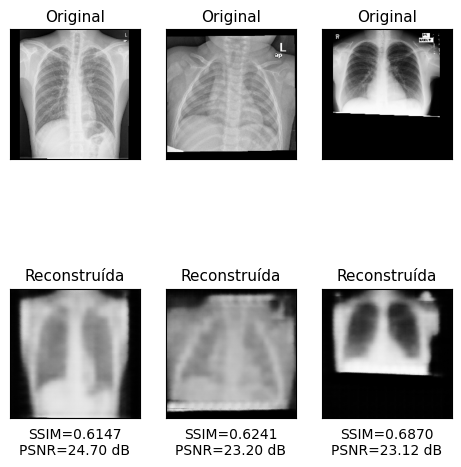

In [ ]:
import os, pandas as pd
from sklearn.model_selection import train_test_split

IMG_DIR_D2 = "/content/drive/MyDrive/TCC/D2/image"  # ajuste se for outra pasta

# lista de arquivos de imagem
files = [f for f in os.listdir(IMG_DIR_D2)
         if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))]
df2_all = pd.DataFrame({"imageId": sorted(files)})

# split 70/15/15 determinístico (sem rótulo mesmo; é só p/ visualização)
df2_train, df2_tmp = train_test_split(df2_all, test_size=0.30, random_state=42, shuffle=True)
df2_val,   df2_test = train_test_split(df2_tmp,  test_size=0.50, random_state=42, shuffle=True)

print(len(df2_train), len(df2_val), len(df2_test))  # só para conferir

BASE_MODELS = "/content/drive/MyDrive/TCC/models"
plot_reconstrucoes_from_df(
    ae_path=f"{BASE_MODELS}/AE_D2_autoencoder.keras",
    df_imgs=df2_test,                      # <<< agora é TESTE
    img_dir=IMG_DIR_D2,
    n=3,
    seed=42,
    channels=1
)
